In [51]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from dmba import plotDecisionTree

# **Clasificación binaria**
-----

In [52]:
def evaluateBinaryClassification(predictions, actuals):

    contingency = pd.crosstab(actuals, predictions)
    
    TP = contingency.loc[1, 1]
    TN = contingency.loc[0, 0]
    FP = contingency.loc[0, 1]
    FN = contingency.loc[1, 0]

    n = contingency.values.sum()

    accuracy = (TP + TN) / n
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1_score = 2 * recall * precision / (recall + precision)
    
    return accuracy, recall, precision, f1_score

# **Carga de datos**
---

In [53]:
df = pd.read_csv('../drinking_water_potability.csv')
df.head(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Potability
0    1998
1    1278
Name: count, dtype: int64


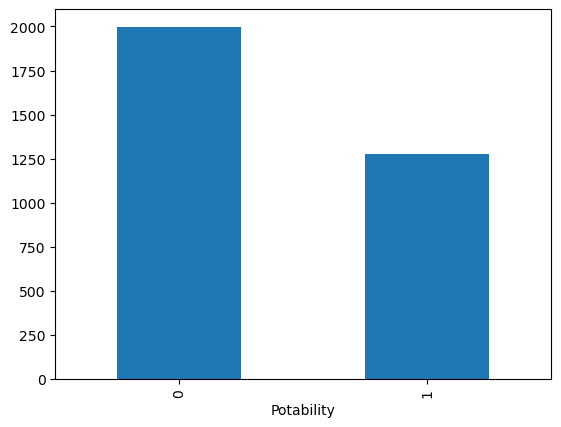

In [54]:
df['Potability'].value_counts().plot(kind='bar')
print(df['Potability'].value_counts())

# **Balanceo**
---

# ** First KNN**
---

In [55]:
df.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [56]:
possible_predictors = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity']
target = 'Potability'

In [57]:
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681736,47580.99160,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.80216,8.061362,333.775777,392.449580,19.903225,66.396293,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,333.775777,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,333.775777,402.883113,11.168946,77.488213,4.708658,1


## **KNN Process**
------

In [58]:
y=df[target]

Xs = pd.get_dummies(df[possible_predictors],drop_first=True)

### *Estandarización de datos*
---

In [59]:
# standardize data
scaler = preprocessing.StandardScaler()

scaler.fit(Xs)  # Note the use of an array of column names

Xs = pd.DataFrame(scaler.transform(Xs),columns =Xs.columns)
Xs.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03
mean,6.506802e-18,-3.491984e-16,-6.506802e-18,-3.806479e-16,8.675735e-17,1.615856e-16,4.370402e-16,-3.730566e-16,-3.448605e-16
std,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00
min,-4.817747e+00,-4.530454e+00,-2.474344e+00,-4.277288e+00,-5.666636e+00,-3.028290e+00,-3.653635e+00,-4.164160e+00,-3.225560e+00
25%,-5.464412e-01,-5.937372e-01,-7.239916e-01,-6.285247e-01,-4.616071e-01,-7.482911e-01,-6.709187e-01,-6.182751e-01,-6.755095e-01
50%,0.000000e+00,1.819424e-02,-1.238999e-01,5.068209e-03,0.000000e+00,-5.345935e-02,-2.014487e-02,0.000000e+00,-1.507005e-02
75%,5.370064e-01,6.174333e-01,6.066532e-01,6.271058e-01,4.596379e-01,6.878605e-01,6.870970e-01,6.513609e-01,6.837866e-01
max,4.707802e+00,3.855680e+00,4.472689e+00,3.793631e+00,4.074895e+00,4.048144e+00,4.237147e+00,3.653325e+00,3.552921e+00


### *Set up experimentation*
---

In [60]:
X_train, X_test, y_train, y_test = train_test_split(Xs,y,  test_size=0.3,random_state=1)

print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

(2293, 9) (983, 9) (2293,) (983,)


## *Selección de features mas importantes*
---

           feature  importance       std
6   Organic_carbon    0.098202  0.016660
8        Turbidity    0.099223  0.017457
7  Trihalomethanes    0.099410  0.016999
5     Conductivity    0.101909  0.016459
2           Solids    0.110768  0.017574
3      Chloramines    0.111683  0.017817
1         Hardness    0.123398  0.018109
4          Sulfate    0.124271  0.017132
0               ph    0.131136  0.019320


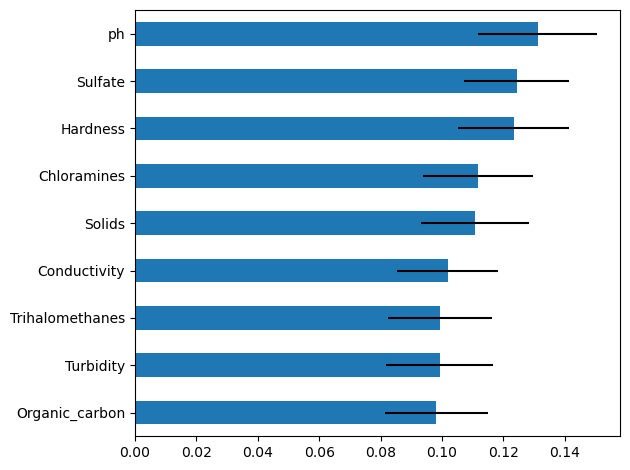

In [61]:
rf = RandomForestClassifier(n_estimators=1000,random_state=2)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df_balanced = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})
df_balanced = df_balanced.sort_values('importance')
print(df_balanced)

ax = df_balanced.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [62]:
select_features=df_balanced[df_balanced.importance>=0.05].feature

# Tuned KNN
----

In [72]:
knn = KNeighborsClassifier(n_neighbors=19,weights='uniform').fit(X_train[select_features], y_train)
y_predict_knn = knn.predict(X_test[select_features])
pd.crosstab(y_test,y_predict_knn)

col_0,0,1
Potability,,
0,522,63
1,287,111


In [73]:
evaluateBinaryClassification(y_predict_knn,y_test)

(0.6439471007121058,
 0.27889447236180903,
 0.6379310344827587,
 0.3881118881118881)

# Naive
---

In [74]:
from sklearn.naive_bayes import MultinomialNB

In [75]:
y = df[target]

In [76]:
Xs = pd.get_dummies(df[possible_predictors],drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(Xs, y,  test_size=0.3,random_state=1)
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

(2293, 9) (983, 9) (2293,) (983,)


In [77]:
nb = MultinomialNB()
nb.fit(X_train[select_features], y_train)

y_predict_nb = nb.predict(X_test[select_features])
pd.crosstab(y_test,y_predict_nb)

col_0,0,1
Potability,,
0,331,254
1,215,183


In [78]:
evaluateBinaryClassification(y_predict_nb,y_test)

(0.5228891149542217,
 0.45979899497487436,
 0.41876430205949655,
 0.4383233532934132)

In [79]:
# predict probabilities
y_prob = nb.predict_proba(X_test[select_features])

summary_df = pd.concat([pd.DataFrame({'actual': y_test, 'predicted': y_predict_nb}),
                pd.DataFrame(y_prob, index=y_test.index,columns = ['No_prob','Yes_prob'])], axis=1)
y_predict_nb = pd.Series(summary_df.Yes_prob>0.9999998888888889).replace({False:0,True:1})

In [80]:
Methods = ['Random','KNN','NB','DT']
Metrics = ['Accuracy','Recall','Precision','Fscore']

compare_df = pd.DataFrame(index = Methods, columns = Metrics)

#Method1 #KNN

compare_df.loc['KNN'] = evaluateBinaryClassification(y_predict_knn,y_test)

number_Yes =  np.sum(y_predict_knn==1)

#Method 2 Random
y_predict_random = pd.Series(np.random.permutation(len(y_test))<number_Yes).replace({False:0,True:1})
print(evaluateBinaryClassification(y_predict_random,y_test))

compare_df.loc['Random'] = evaluateBinaryClassification(y_predict_random,y_test)

#Method 3 NB
compare_df.loc['NB'] = evaluateBinaryClassification(y_predict_nb,y_test)
compare_df

(0.6163934426229508, 0.1836734693877551, 0.32727272727272727, 0.23529411764705885)


,Accuracy,Recall,Precision,Fscore
Random,0.616393,0.183673,0.327273,0.235294
KNN,0.643947,0.278894,0.637931,0.388112
NB,0.601221,0.143216,0.527778,0.225296
DT,NaN,NaN,NaN,NaN


In [81]:
print('Random Method number of yes prediction: {}'.format(np.sum(y_predict_random==1)))
print('KNN Method number of yes prediction: {}'.format(np.sum(y_predict_knn==1)))
print('NB Method number of yes prediction: {}'.format(np.sum(y_predict_nb==1)))

Random Method number of yes prediction: 174
KNN Method number of yes prediction: 174
NB Method number of yes prediction: 108


# DT

## DT Process

In [ ]:
y=df[target]

Xs = pd.DataFrame(df)

In [ ]:
Xs = pd.get_dummies(Xs[possible_predictors],drop_first=True)

In [ ]:
Xs.fillna(Xs.median(),inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xs,y,  test_size=0.3,random_state=1)
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

# Tuned DT

In [ ]:
classTree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 7,
                                   min_impurity_decrease= 0.005, min_samples_split= 16, splitter= 'best')
classTree.fit(X_train, y_train)

plotDecisionTree(classTree, feature_names=X_train.columns, class_names=classTree.classes_)

# Comapre

In [ ]:
y_predict_dt = classTree.predict(X_test)
compare_df.loc['DT'] = evaluateBinaryClassification(y_predict_dt,y_test)
compare_df

In [ ]:
print('Random Method number of yes prediction: {}'.format(np.sum(y_predict_random==1)))
print('KNN Method number of yes prediction: {}'.format(np.sum(y_predict_knn==1)))
print('NB Method number of yes prediction: {}'.format(np.sum(y_predict_nb==1)))
print('DT Method number of yes prediction: {}'.format(np.sum(y_predict_dt==1)))

# Clasificación MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(random_state=5)
mlp.fit(X_train, y_train)
y_predict_mlp = mlp.predict(X_test)

In [ ]:
compare_df.loc['MLP'] = evaluateBinaryClassification(y_predict_mlp,y_test)
compare_df

In [ ]:
print('Random Method number of yes prediction: {}'.format(np.sum(y_predict_random==1)))
print('KNN Method number of yes prediction: {}'.format(np.sum(y_predict_knn==1)))
print('NB Method number of yes prediction: {}'.format(np.sum(y_predict_nb==1)))
print('DT Method number of yes prediction: {}'.format(np.sum(y_predict_dt==1)))
print('MLP Method number of yes prediction: {}'.format(np.sum(y_predict_mlp==1)))
# Tune MLP

# Tune MLP

In [63]:
from sklearn.model_selection import ShuffleSplit

In [64]:
import warnings

warnings.filterwarnings("ignore")

In [65]:
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

param_grid = {
    'hidden_layer_sizes':[5],
    'activation': ['identity','logistic','tanh','relu'],
    'solver': ['lbfgs','sgd','adam'],
    'learning_rate':['constant','invscaling','adaptive']}

gridSearch = GridSearchCV(MLPClassifier(), param_grid, cv=cv,
                          scoring=['recall','f1'],refit='f1',verbose=2)
gridSearch.fit(X_train, y_train)
print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=constant, solver=lbfgs; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=invscaling, solver=lbfgs; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=invscaling, solver=sgd; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=invscaling, solver=adam; total time=   0.1s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=adaptive, solver=lbfgs; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=adaptive, solver=sgd; total time=   0.7s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=ada

In [66]:
param_grid = {
    'hidden_layer_sizes':[5,9,15,(5,5),(5,10)],
    'activation': ['relu'],
    'solver': ['adam'],
    'learning_rate':['invscaling']
}

gridSearch = GridSearchCV(MLPClassifier(), param_grid, cv=cv,
                          scoring='recall',verbose=2)
gridSearch.fit(X_train, y_train)
print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV] END activation=relu, hidden_layer_sizes=5, learning_rate=invscaling, solver=adam; total time=   0.6s
[CV] END activation=relu, hidden_layer_sizes=9, learning_rate=invscaling, solver=adam; total time=   0.5s
[CV] END activation=relu, hidden_layer_sizes=15, learning_rate=invscaling, solver=adam; total time=   0.7s
[CV] END activation=relu, hidden_layer_sizes=(5, 5), learning_rate=invscaling, solver=adam; total time=   0.7s
[CV] END activation=relu, hidden_layer_sizes=(5, 10), learning_rate=invscaling, solver=adam; total time=   0.7s
Score:  0.38650306748466257
Parameters:  {'activation': 'relu', 'hidden_layer_sizes': 9, 'learning_rate': 'invscaling', 'solver': 'adam'}


In [67]:
param_grid = {
    'hidden_layer_sizes':[4,9,15,(5,5),(5,10)],
    'activation': ['identity'],
    'solver': ['adam'],
    'alpha': [0,0.0005,0.0001,0.0005,0.001],
    'learning_rate':['invscaling'],
    'learning_rate_init': [0,0.0001,0.0005,0.001, 0.005,0.01],
    'max_iter': [200,500],
    'shuffle': [True,False] 
}

gridSearch = GridSearchCV(MLPClassifier(), param_grid, cv=cv,
                          scoring='recall',verbose=2)
gridSearch.fit(X_train, y_train)
print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 1 folds for each of 600 candidates, totalling 600 fits
[CV] END activation=identity, alpha=0, hidden_layer_sizes=4, learning_rate=invscaling, learning_rate_init=0, max_iter=200, shuffle=True, solver=adam; total time=   0.0s
[CV] END activation=identity, alpha=0, hidden_layer_sizes=4, learning_rate=invscaling, learning_rate_init=0, max_iter=200, shuffle=False, solver=adam; total time=   0.0s
[CV] END activation=identity, alpha=0, hidden_layer_sizes=4, learning_rate=invscaling, learning_rate_init=0, max_iter=500, shuffle=True, solver=adam; total time=   0.0s
[CV] END activation=identity, alpha=0, hidden_layer_sizes=4, learning_rate=invscaling, learning_rate_init=0, max_iter=500, shuffle=False, solver=adam; total time=   0.0s
[CV] END activation=identity, alpha=0, hidden_layer_sizes=4, learning_rate=invscaling, learning_rate_init=0.0001, max_iter=200, shuffle=True, solver=adam; total time=   1.0s
[CV] END activation=identity, alpha=0, hidden_layer_sizes=4, learning_rate=invscaling

In [85]:
X_train_s, X_tune, y_train_s, y_tune = train_test_split(X_train, y_train, test_size=0.2)

for i in range(15):
    mlp = MLPClassifier(hidden_layer_sizes=5,activation='relu',
                        learning_rate='invscaling', solver='adam',
                        random_state=i)
    
    mlp.fit(X_train_s, y_train_s)
    y_predict_mlp = mlp.predict(X_tune)
    print(i,evaluateBinaryClassification(y_predict_mlp,y_tune))       

0 (0.4793028322440087, 0.4722222222222222, 0.37117903930131, 0.41564792176039117)
1 (0.5969498910675382, 0.1111111111111111, 0.4444444444444444, 0.17777777777777776)
2 (0.43137254901960786, 0.8, 0.3902439024390244, 0.5245901639344263)
3 (0.5315904139433552, 0.38333333333333336, 0.3988439306358382, 0.3909348441926346)
4 (0.4444444444444444, 0.6888888888888889, 0.38390092879256965, 0.4930417495029821)
5 (0.4684095860566449, 0.5222222222222223, 0.373015873015873, 0.4351851851851852)


KeyError: 1

In [83]:
mlp = MLPClassifier(hidden_layer_sizes=5, activation='relu', learning_rate='invscaling', solver='adam', random_state=13)
mlp.fit(X_train_s, y_train_s)
y_predict_mlp = mlp.predict(X_test)

In [84]:
compare_df.loc['MLP'] = evaluateBinaryClassification(y_predict_mlp,y_test)
compare_df

,Accuracy,Recall,Precision,Fscore
Random,0.616393,0.183673,0.327273,0.235294
KNN,0.643947,0.278894,0.637931,0.388112
NB,0.601221,0.143216,0.527778,0.225296
DT,NaN,NaN,NaN,NaN
MLP,0.400814,0.974874,0.401241,0.568498


In [ ]:
print('Random Method number of yes prediction: {}'.format(np.sum(y_predict_random==1)))
print('KNN Method number of yes prediction: {}'.format(np.sum(y_predict_knn==1)))
print('NB Method number of yes prediction: {}'.format(np.sum(y_predict_nb==1)))
print('DT Method number of yes prediction: {}'.format(np.sum(y_predict_dt==1)))
print('MLP Method number of yes prediction: {}'.format(np.sum(y_predict_mlp==1)))